In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from fancyimpute import KNN
from tqdm import tqdm
from src.preprocess import batch_process
from src.read_data import read_datasets, merge_phylo_data


In [2]:
phylo = pd.read_csv('./data/derived/merged_phylo_data.csv')

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_34463/364389351.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/merged_phylo_data.csv')


In [3]:
num_samples = phylo['RENAME_ID'].nunique()
print('The number of unique samples:', num_samples, '\n')
num_windows = phylo['xcoord'].nunique()
print('The number of windows in a sample:', num_windows, '\n')

The number of unique samples: 1280 

The number of windows in a sample: 355 



In [4]:
missing_fraction_per_sample = phylo.groupby('RENAME_ID')['normalised.largest.rtt'].apply(lambda x: x.isnull().mean())
num_samples_above_threshold = (missing_fraction_per_sample > 0.4).sum()
print(f"Number of samples with more than 40% missing data in 'normalised.largest.rtt': {num_samples_above_threshold}")

Number of samples with more than 40% missing data in 'normalised.largest.rtt': 627


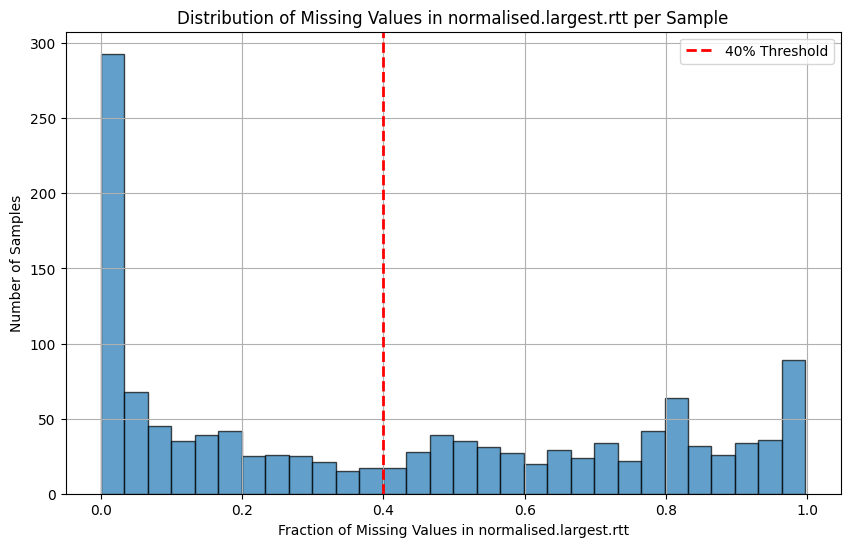

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(missing_fraction_per_sample, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0.4, color='red', linestyle='dashed', linewidth=2, label='40% Threshold')
plt.xlabel('Fraction of Missing Values in normalised.largest.rtt')
plt.ylabel('Number of Samples')
plt.title('Distribution of Missing Values in normalised.largest.rtt per Sample')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
missing_fraction_per_window = phylo.groupby('xcoord')['normalised.largest.rtt'].apply(lambda x: x.isnull().mean())
num_windows_above_threshold = (missing_fraction_per_window > 0.4).sum()
print(f"Number of windows with more than 40% missing data in 'normalised.largest.rtt': {num_windows_above_threshold}")

Number of windows with more than 40% missing data in 'normalised.largest.rtt': 226


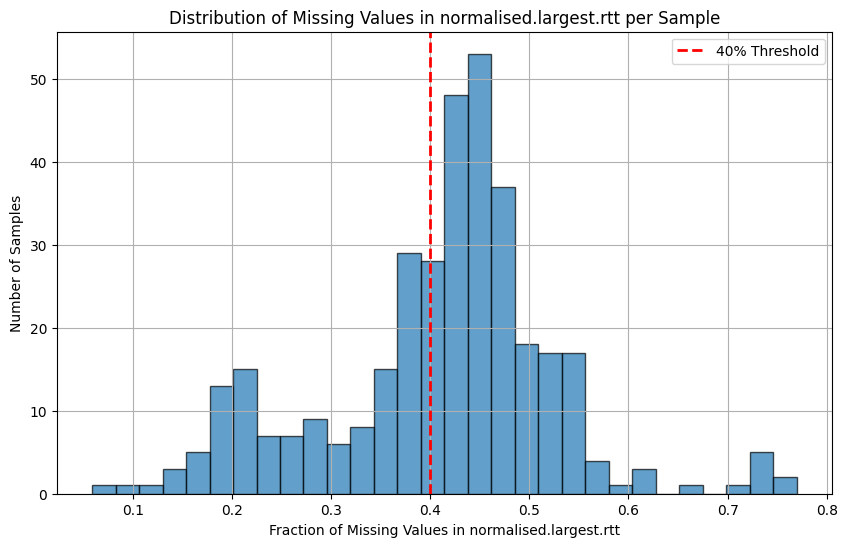

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(missing_fraction_per_window, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0.4, color='red', linestyle='dashed', linewidth=2, label='40% Threshold')
plt.xlabel('Fraction of Missing Values in normalised.largest.rtt')
plt.ylabel('Number of Samples')
plt.title('Distribution of Missing Values in normalised.largest.rtt per Sample')
plt.legend()
plt.grid(True)
plt.show()

# FILTER

In [9]:
# Identify samples and windows with more than 40% missing data
samples_to_remove = missing_fraction_per_sample[missing_fraction_per_sample > 0.4].index
windows_to_remove = missing_fraction_per_window[missing_fraction_per_window > 0.4].index

filtered_phylo = phylo[~phylo['RENAME_ID'].isin(samples_to_remove) & ~phylo['xcoord'].isin(windows_to_remove)]


In [10]:
num_samples = filtered_phylo['RENAME_ID'].nunique()
print('The number of unique samples:', num_samples, '\n')
num_windows = filtered_phylo['xcoord'].nunique()
print('The number of windows in a sample:', num_windows, '\n')

The number of unique samples: 653 

The number of windows in a sample: 129 



# IMPUTATION

In [11]:
columns_for_imputation = [
    'overall.rtt', 'largest.rtt', 'max.branch.length', 'max.pat.distance',
    'global.mean.pat.distance', 'normalised.largest.rtt', 'normalised.max.branch.length',
    'normalised.max.pat.distance', 'normalised.global.mean.pat.distance', 'normalised.subgraph.mean.pat.distance'
]

In [12]:
id_indicators = filtered_phylo[['RENAME_ID','TSI_days', 'xcoord']]

In [16]:
# Extract numeric columns for imputation
data_for_imputation = filtered_phylo[columns_for_imputation]

print(f"Data for imputation shape: {data_for_imputation.shape}")
missing_values_count = data_for_imputation['normalised.largest.rtt'].isna().sum()

# Print the count of missing values
print(f"Number of missing values in normalised.largest.rtt': {missing_values_count}")

Data for imputation shape: (82707, 10)
Number of missing values in normalised.largest.rtt': 3080


In [29]:
# Step 6: Standardize the selected columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_imputation)

# Check the scaled data
print(f"Scaled data shape: {scaled_data.shape}")

Scaled data shape: (82707, 10)


In [30]:
def batch_process(data, batch_size, imputer, scaler):
    n_batches = int(np.ceil(data.shape[0] / batch_size))
    imputed_data = []
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, data.shape[0])
        batch_data = data[start_idx:end_idx]
        
        scaled_batch_data = scaler.transform(batch_data)
        imputed_batch_data = imputer.fit_transform(scaled_batch_data)
        imputed_batch_data_original_scale = scaler.inverse_transform(imputed_batch_data)
        
        imputed_data.append(imputed_batch_data_original_scale)
    
    return np.vstack(imputed_data)

# Standardize the selected columns
scaler = StandardScaler()

# Perform KNN imputation using fancyimpute in batches
batch_size = 10000  # Adjust the batch size as needed
knn_imputer = KNN(k=3)
imputed_data_batches = batch_process(data_for_imputation.values, batch_size, knn_imputer, scaler)

# Convert the imputed data back to the original scale
imputed_df = pd.DataFrame(imputed_data_batches, columns=columns_for_imputation, index=filtered_phylo.index)
filtered_phylo.update(imputed_df)

print("Batch imputation completed successfully.")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 15.335
Imputing row 101/10000 with 0 missing, elapsed time: 15.335
Imputing row 201/10000 with 0 missing, elapsed time: 15.338
Imputing row 301/10000 with 0 missing, elapsed time: 15.339
Imputing row 401/10000 with 0 missing, elapsed time: 15.339
Imputing row 501/10000 with 0 missing, elapsed time: 15.339
Imputing row 601/10000 with 0 missing, elapsed time: 15.339
Imputing row 701/10000 with 0 missing, elapsed time: 15.340
Imputing row 801/10000 with 0 missing, elapsed time: 15.340
Imputing row 901/10000 with 0 missing, elapsed time: 15.340
Imputing row 1001/10000 with 0 missing, elapsed time: 15.341
Imputing row 1101/10000 with 10 missing, elapsed time: 15.341
Imputing row 1201/10000 with 0 missing, elapsed time: 15.342
Imputing row 1301/10000 with 0 missing, elapsed time: 15.345
Imputing row 1401/10000 with 0 missing, elapsed time: 15.347
Imputing row 1501/10000 with 0 missing, elapsed time: 15.347
Imputing row 1601/10000 with 0 miss

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 15.011
Imputing row 101/10000 with 1 missing, elapsed time: 15.019
Imputing row 201/10000 with 1 missing, elapsed time: 15.026
Imputing row 301/10000 with 0 missing, elapsed time: 15.033
Imputing row 401/10000 with 0 missing, elapsed time: 15.035
Imputing row 501/10000 with 1 missing, elapsed time: 15.040
Imputing row 601/10000 with 1 missing, elapsed time: 15.046
Imputing row 701/10000 with 0 missing, elapsed time: 15.053
Imputing row 801/10000 with 1 missing, elapsed time: 15.061
Imputing row 901/10000 with 1 missing, elapsed time: 15.066
Imputing row 1001/10000 with 1 missing, elapsed time: 15.073
Imputing row 1101/10000 with 0 missing, elapsed time: 15.078
Imputing row 1201/10000 with 1 missing, elapsed time: 15.085
Imputing row 1301/10000 with 0 missing, elapsed time: 15.096
Imputing row 1401/10000 with 1 missing, elapsed time: 15.098
Imputing row 1501/10000 with 1 missing, elapsed time: 15.110
Imputing row 1601/10000 with 1 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 1 missing, elapsed time: 14.774
Imputing row 101/10000 with 1 missing, elapsed time: 14.779
Imputing row 201/10000 with 1 missing, elapsed time: 14.787
Imputing row 301/10000 with 0 missing, elapsed time: 14.791
Imputing row 401/10000 with 1 missing, elapsed time: 14.797
Imputing row 501/10000 with 1 missing, elapsed time: 14.804
Imputing row 601/10000 with 1 missing, elapsed time: 14.811
Imputing row 701/10000 with 1 missing, elapsed time: 14.818
Imputing row 801/10000 with 0 missing, elapsed time: 14.824
Imputing row 901/10000 with 0 missing, elapsed time: 14.831
Imputing row 1001/10000 with 0 missing, elapsed time: 14.834
Imputing row 1101/10000 with 0 missing, elapsed time: 14.835
Imputing row 1201/10000 with 0 missing, elapsed time: 14.839
Imputing row 1301/10000 with 1 missing, elapsed time: 14.845
Imputing row 1401/10000 with 0 missing, elapsed time: 14.852
Imputing row 1501/10000 with 1 missing, elapsed time: 14.858
Imputing row 1601/10000 with 1 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 1 missing, elapsed time: 14.388
Imputing row 101/10000 with 1 missing, elapsed time: 14.398
Imputing row 201/10000 with 0 missing, elapsed time: 14.403
Imputing row 301/10000 with 0 missing, elapsed time: 14.406
Imputing row 401/10000 with 1 missing, elapsed time: 14.409
Imputing row 501/10000 with 0 missing, elapsed time: 14.414
Imputing row 601/10000 with 1 missing, elapsed time: 14.415
Imputing row 701/10000 with 0 missing, elapsed time: 14.420
Imputing row 801/10000 with 10 missing, elapsed time: 14.427
Imputing row 901/10000 with 1 missing, elapsed time: 14.434
Imputing row 1001/10000 with 1 missing, elapsed time: 14.441
Imputing row 1101/10000 with 1 missing, elapsed time: 14.447
Imputing row 1201/10000 with 0 missing, elapsed time: 14.454
Imputing row 1301/10000 with 0 missing, elapsed time: 14.455
Imputing row 1401/10000 with 1 missing, elapsed time: 14.461
Imputing row 1501/10000 with 1 missing, elapsed time: 14.469
Imputing row 1601/10000 with 1 miss

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 13.613
Imputing row 101/10000 with 0 missing, elapsed time: 13.613
Imputing row 201/10000 with 0 missing, elapsed time: 13.613
Imputing row 301/10000 with 7 missing, elapsed time: 13.618
Imputing row 401/10000 with 0 missing, elapsed time: 13.621
Imputing row 501/10000 with 0 missing, elapsed time: 13.621
Imputing row 601/10000 with 0 missing, elapsed time: 13.621
Imputing row 701/10000 with 0 missing, elapsed time: 13.622
Imputing row 801/10000 with 0 missing, elapsed time: 13.622
Imputing row 901/10000 with 0 missing, elapsed time: 13.622
Imputing row 1001/10000 with 0 missing, elapsed time: 13.622
Imputing row 1101/10000 with 0 missing, elapsed time: 13.623
Imputing row 1201/10000 with 0 missing, elapsed time: 13.623
Imputing row 1301/10000 with 0 missing, elapsed time: 13.623
Imputing row 1401/10000 with 0 missing, elapsed time: 13.624
Imputing row 1501/10000 with 0 missing, elapsed time: 13.624
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 13.808
Imputing row 101/10000 with 0 missing, elapsed time: 13.809
Imputing row 201/10000 with 0 missing, elapsed time: 13.809
Imputing row 301/10000 with 0 missing, elapsed time: 13.809
Imputing row 401/10000 with 0 missing, elapsed time: 13.809
Imputing row 501/10000 with 0 missing, elapsed time: 13.810
Imputing row 601/10000 with 0 missing, elapsed time: 13.811
Imputing row 701/10000 with 0 missing, elapsed time: 13.811
Imputing row 801/10000 with 0 missing, elapsed time: 13.811
Imputing row 901/10000 with 0 missing, elapsed time: 13.813
Imputing row 1001/10000 with 0 missing, elapsed time: 13.814
Imputing row 1101/10000 with 0 missing, elapsed time: 13.814
Imputing row 1201/10000 with 0 missing, elapsed time: 13.815
Imputing row 1301/10000 with 7 missing, elapsed time: 13.816
Imputing row 1401/10000 with 0 missing, elapsed time: 13.817
Imputing row 1501/10000 with 0 missing, elapsed time: 13.817
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 14.058
Imputing row 101/10000 with 0 missing, elapsed time: 14.059
Imputing row 201/10000 with 0 missing, elapsed time: 14.060
Imputing row 301/10000 with 0 missing, elapsed time: 14.060
Imputing row 401/10000 with 0 missing, elapsed time: 14.061
Imputing row 501/10000 with 0 missing, elapsed time: 14.062
Imputing row 601/10000 with 0 missing, elapsed time: 14.063
Imputing row 701/10000 with 0 missing, elapsed time: 14.063
Imputing row 801/10000 with 0 missing, elapsed time: 14.063
Imputing row 901/10000 with 0 missing, elapsed time: 14.065
Imputing row 1001/10000 with 0 missing, elapsed time: 14.065
Imputing row 1101/10000 with 0 missing, elapsed time: 14.067
Imputing row 1201/10000 with 0 missing, elapsed time: 14.067
Imputing row 1301/10000 with 0 missing, elapsed time: 14.068
Imputing row 1401/10000 with 0 missing, elapsed time: 14.068
Imputing row 1501/10000 with 0 missing, elapsed time: 14.069
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 13.960
Imputing row 101/10000 with 0 missing, elapsed time: 13.961
Imputing row 201/10000 with 0 missing, elapsed time: 13.962
Imputing row 301/10000 with 0 missing, elapsed time: 13.963
Imputing row 401/10000 with 0 missing, elapsed time: 13.963
Imputing row 501/10000 with 0 missing, elapsed time: 13.963
Imputing row 601/10000 with 0 missing, elapsed time: 13.964
Imputing row 701/10000 with 0 missing, elapsed time: 13.967
Imputing row 801/10000 with 0 missing, elapsed time: 13.967
Imputing row 901/10000 with 0 missing, elapsed time: 13.967
Imputing row 1001/10000 with 0 missing, elapsed time: 13.968
Imputing row 1101/10000 with 0 missing, elapsed time: 13.969
Imputing row 1201/10000 with 0 missing, elapsed time: 13.970
Imputing row 1301/10000 with 0 missing, elapsed time: 13.970
Imputing row 1401/10000 with 0 missing, elapsed time: 13.970
Imputing row 1501/10000 with 0 missing, elapsed time: 13.971
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/2707 with 10 missing, elapsed time: 0.942
Imputing row 101/2707 with 0 missing, elapsed time: 0.943
Imputing row 201/2707 with 0 missing, elapsed time: 0.944
Imputing row 301/2707 with 0 missing, elapsed time: 0.944
Imputing row 401/2707 with 0 missing, elapsed time: 0.944
Imputing row 501/2707 with 0 missing, elapsed time: 0.945
Imputing row 601/2707 with 10 missing, elapsed time: 0.946
Imputing row 701/2707 with 0 missing, elapsed time: 0.946
Imputing row 801/2707 with 0 missing, elapsed time: 0.947
Imputing row 901/2707 with 10 missing, elapsed time: 0.949
Imputing row 1001/2707 with 0 missing, elapsed time: 0.950
Imputing row 1101/2707 with 0 missing, elapsed time: 0.950
Imputing row 1201/2707 with 0 missing, elapsed time: 0.951
Imputing row 1301/2707 with 0 missing, elapsed time: 0.951
Imputing row 1401/2707 with 0 missing, elapsed time: 0.953
Imputing row 1501/2707 with 0 missing, elapsed time: 0.953
Imputing row 1601/2707 with 0 missing, elapsed time: 0.956
Imputi

In [32]:
filtered_phylo.to_csv('./data/derived/imputed_phylo_data.csv', index=False)

# MAF

## Description

In [43]:
maf = pd.read_csv('./data/derived/window_MAF.csv')

In [44]:
num_samples = maf['RENAME_ID'].nunique()
print('The number of unique samples:', num_samples, '\n')
num_windows = maf['Window_Centre'].nunique()
print('The number of windows in a sample:', num_windows, '\n')

The number of unique samples: 1206 

The number of windows in a sample: 339 



## Filtering

In [45]:
# Calculate missing fractions for windows
missing_fraction_per_window_12c = maf.groupby('Window_Centre')['MAF12c_Mean'].apply(lambda x: x.isnull().mean())
missing_fraction_per_window_3c = maf.groupby('Window_Centre')['MAF3c_Mean'].apply(lambda x: x.isnull().mean())

# Identify windows with more than 40% missing data
windows_to_exclude_12c = missing_fraction_per_window_12c[missing_fraction_per_window_12c > 0.4].index
windows_to_exclude_3c = missing_fraction_per_window_3c[missing_fraction_per_window_3c > 0.4].index

# Combine the windows to exclude from both MAF12c_Mean and MAF3c_Mean
windows_to_exclude = windows_to_exclude_12c.union(windows_to_exclude_3c)

# Compute number of samples to filter out
num_windows_above_threshold_12c = (missing_fraction_per_window_12c > 0.4).sum()
num_windows_above_threshold_3c = (missing_fraction_per_window_3c > 0.4).sum()

# Print results
print(f"Number of windows with more than 40% missing data in 'MAF12c_Mean': {num_windows_above_threshold_12c}")
print(f"Number of windows with more than 40% missing data in 'MAF3c_Mean': {num_windows_above_threshold_3c}")

Number of windows with more than 40% missing data in 'MAF12c_Mean': 0
Number of windows with more than 40% missing data in 'MAF3c_Mean': 1


In [47]:
# Calculate missing fractions for samples
missing_fraction_per_sample_12c = maf.groupby('RENAME_ID')['MAF12c_Mean'].apply(lambda x: x.isnull().mean())
missing_fraction_per_sample_3c = maf.groupby('RENAME_ID')['MAF3c_Mean'].apply(lambda x: x.isnull().mean())

# Identify samples with more than 40% missing data
samples_to_exclude_12c = missing_fraction_per_sample_12c[missing_fraction_per_sample_12c > 0.4].index
samples_to_exclude_3c = missing_fraction_per_sample_3c[missing_fraction_per_sample_3c > 0.4].index

# Combine the samples to exclude from both MAF12c_Mean and MAF3c_Mean
samples_to_exclude = samples_to_exclude_12c.union(samples_to_exclude_3c)
num_samples_to_filter_out = len(samples_to_exclude)

# Compute number of samples to filter out
num_samples_above_threshold_12c = (missing_fraction_per_sample_12c > 0.4).sum()
num_samples_above_threshold_3c = (missing_fraction_per_sample_3c > 0.4).sum()

# Print results
print(f"Number of samples with more than 40% missing data in 'MAF12c_Mean': {num_samples_above_threshold_12c}")
print(f"Number of samples with more than 40% missing data in 'MAF3c_Mean': {num_samples_above_threshold_3c}")
print(f"Total number of unique samples to filter out: {num_samples_to_filter_out}")

Number of samples with more than 40% missing data in 'MAF12c_Mean': 137
Number of samples with more than 40% missing data in 'MAF3c_Mean': 139


In [48]:
filtered_maf = maf[
    ~maf['Window_Centre'].isin(windows_to_exclude) &
    ~maf['RENAME_ID'].isin(samples_to_exclude)
]

print(f"Original DataFrame shape: {maf.shape}")
print(f"Filtered DataFrame shape: {filtered_maf.shape}")

Original DataFrame shape: (417309, 8)
Filtered DataFrame shape: (369096, 8)


## KNN Imputation

In [49]:
columns_for_imputation = ['MAF12c_Mean', 'MAF3c_Mean']
id_indicators = filtered_maf[['RENAME_ID','TSI_days', 'Window_Centre']]

missing_maf12c = filtered_maf['MAF12c_Mean'].isna().sum()
missing_maf3c = filtered_maf['MAF3c_Mean'].isna().sum()

# Print the count of missing values
print(f"Number of missing values in MAF12c_Mean: {missing_maf12c}")
print(f"Number of missing values in MAF3c_Mean: {missing_maf3c}")

Number of missing values in MAF12c_Mean: 15172
Number of missing values in MAF3c_Mean: 15583


In [51]:
# Extract numeric columns for imputation
data_for_imputation = filtered_maf[columns_for_imputation]

# Standardize the selected columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_imputation)

# Perform KNN imputation using fancyimpute in batches
batch_size = 10000 
knn_imputer = KNN(k=3)
imputed_data_batches = batch_process(data_for_imputation.values, batch_size, knn_imputer, scaler)

# Convert the imputed data back to the original scale
imputed_df = pd.DataFrame(imputed_data_batches, columns=columns_for_imputation, index=filtered_maf.index)
filtered_maf.update(imputed_df)

print("Batch imputation completed successfully.")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 14.375
Imputing row 101/10000 with 0 missing, elapsed time: 14.376
Imputing row 201/10000 with 0 missing, elapsed time: 14.376
Imputing row 301/10000 with 0 missing, elapsed time: 14.376
Imputing row 401/10000 with 0 missing, elapsed time: 14.376
Imputing row 501/10000 with 0 missing, elapsed time: 14.377
Imputing row 601/10000 with 0 missing, elapsed time: 14.377
Imputing row 701/10000 with 0 missing, elapsed time: 14.377
Imputing row 801/10000 with 0 missing, elapsed time: 14.377
Imputing row 901/10000 with 0 missing, elapsed time: 14.377
Imputing row 1001/10000 with 0 missing, elapsed time: 14.378
Imputing row 1101/10000 with 0 missing, elapsed time: 14.378
Imputing row 1201/10000 with 0 missing, elapsed time: 14.378
Imputing row 1301/10000 with 0 missing, elapsed time: 14.378
Imputing row 1401/10000 with 0 missing, elapsed time: 14.378
Imputing row 1501/10000 with 0 missing, elapsed time: 14.379
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 13.074
Imputing row 101/10000 with 0 missing, elapsed time: 13.074
Imputing row 201/10000 with 0 missing, elapsed time: 13.074
Imputing row 301/10000 with 0 missing, elapsed time: 13.075
Imputing row 401/10000 with 0 missing, elapsed time: 13.075
Imputing row 501/10000 with 0 missing, elapsed time: 13.075
Imputing row 601/10000 with 0 missing, elapsed time: 13.075
Imputing row 701/10000 with 0 missing, elapsed time: 13.075
Imputing row 801/10000 with 0 missing, elapsed time: 13.076
Imputing row 901/10000 with 0 missing, elapsed time: 13.076
Imputing row 1001/10000 with 0 missing, elapsed time: 13.076
Imputing row 1101/10000 with 0 missing, elapsed time: 13.076
Imputing row 1201/10000 with 0 missing, elapsed time: 13.076
Imputing row 1301/10000 with 0 missing, elapsed time: 13.077
Imputing row 1401/10000 with 0 missing, elapsed time: 13.077
Imputing row 1501/10000 with 0 missing, elapsed time: 13.077
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 13.363
Imputing row 101/10000 with 0 missing, elapsed time: 13.363
Imputing row 201/10000 with 0 missing, elapsed time: 13.363
Imputing row 301/10000 with 0 missing, elapsed time: 13.363
Imputing row 401/10000 with 0 missing, elapsed time: 13.364
Imputing row 501/10000 with 0 missing, elapsed time: 13.364
Imputing row 601/10000 with 0 missing, elapsed time: 13.364
Imputing row 701/10000 with 0 missing, elapsed time: 13.364
Imputing row 801/10000 with 0 missing, elapsed time: 13.365
Imputing row 901/10000 with 0 missing, elapsed time: 13.365
Imputing row 1001/10000 with 0 missing, elapsed time: 13.365
Imputing row 1101/10000 with 0 missing, elapsed time: 13.365
Imputing row 1201/10000 with 0 missing, elapsed time: 13.365
Imputing row 1301/10000 with 0 missing, elapsed time: 13.365
Imputing row 1401/10000 with 0 missing, elapsed time: 13.366
Imputing row 1501/10000 with 0 missing, elapsed time: 13.366
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 14.583
Imputing row 101/10000 with 0 missing, elapsed time: 14.583
Imputing row 201/10000 with 0 missing, elapsed time: 14.584
Imputing row 301/10000 with 0 missing, elapsed time: 14.584
Imputing row 401/10000 with 0 missing, elapsed time: 14.584
Imputing row 501/10000 with 0 missing, elapsed time: 14.584
Imputing row 601/10000 with 0 missing, elapsed time: 14.585
Imputing row 701/10000 with 0 missing, elapsed time: 14.585
Imputing row 801/10000 with 0 missing, elapsed time: 14.585
Imputing row 901/10000 with 0 missing, elapsed time: 14.585
Imputing row 1001/10000 with 0 missing, elapsed time: 14.585
Imputing row 1101/10000 with 0 missing, elapsed time: 14.586
Imputing row 1201/10000 with 0 missing, elapsed time: 14.586
Imputing row 1301/10000 with 0 missing, elapsed time: 14.586
Imputing row 1401/10000 with 0 missing, elapsed time: 14.586
Imputing row 1501/10000 with 0 missing, elapsed time: 14.586
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 13.023
Imputing row 101/10000 with 0 missing, elapsed time: 13.024
Imputing row 201/10000 with 0 missing, elapsed time: 13.024
Imputing row 301/10000 with 0 missing, elapsed time: 13.024
Imputing row 401/10000 with 0 missing, elapsed time: 13.024
Imputing row 501/10000 with 0 missing, elapsed time: 13.025
Imputing row 601/10000 with 0 missing, elapsed time: 13.025
Imputing row 701/10000 with 0 missing, elapsed time: 13.025
Imputing row 801/10000 with 0 missing, elapsed time: 13.025
Imputing row 901/10000 with 0 missing, elapsed time: 13.025
Imputing row 1001/10000 with 0 missing, elapsed time: 13.026
Imputing row 1101/10000 with 0 missing, elapsed time: 13.026
Imputing row 1201/10000 with 0 missing, elapsed time: 13.026
Imputing row 1301/10000 with 0 missing, elapsed time: 13.026
Imputing row 1401/10000 with 0 missing, elapsed time: 13.026
Imputing row 1501/10000 with 0 missing, elapsed time: 13.027
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 18.235
Imputing row 101/10000 with 0 missing, elapsed time: 18.236
Imputing row 201/10000 with 0 missing, elapsed time: 18.236
Imputing row 301/10000 with 0 missing, elapsed time: 18.236
Imputing row 401/10000 with 0 missing, elapsed time: 18.237
Imputing row 501/10000 with 0 missing, elapsed time: 18.237
Imputing row 601/10000 with 0 missing, elapsed time: 18.237
Imputing row 701/10000 with 0 missing, elapsed time: 18.237
Imputing row 801/10000 with 0 missing, elapsed time: 18.237
Imputing row 901/10000 with 0 missing, elapsed time: 18.238
Imputing row 1001/10000 with 0 missing, elapsed time: 18.238
Imputing row 1101/10000 with 0 missing, elapsed time: 18.238
Imputing row 1201/10000 with 0 missing, elapsed time: 18.238
Imputing row 1301/10000 with 0 missing, elapsed time: 18.239
Imputing row 1401/10000 with 0 missing, elapsed time: 18.239
Imputing row 1501/10000 with 0 missing, elapsed time: 18.239
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 14.685
Imputing row 101/10000 with 0 missing, elapsed time: 14.685
Imputing row 201/10000 with 0 missing, elapsed time: 14.685
Imputing row 301/10000 with 0 missing, elapsed time: 14.685
Imputing row 401/10000 with 0 missing, elapsed time: 14.686
Imputing row 501/10000 with 0 missing, elapsed time: 14.686
Imputing row 601/10000 with 0 missing, elapsed time: 14.686
Imputing row 701/10000 with 0 missing, elapsed time: 14.686
Imputing row 801/10000 with 0 missing, elapsed time: 14.686
Imputing row 901/10000 with 0 missing, elapsed time: 14.687
Imputing row 1001/10000 with 0 missing, elapsed time: 14.687
Imputing row 1101/10000 with 0 missing, elapsed time: 14.687
Imputing row 1201/10000 with 0 missing, elapsed time: 14.687
Imputing row 1301/10000 with 0 missing, elapsed time: 14.687
Imputing row 1401/10000 with 0 missing, elapsed time: 14.688
Imputing row 1501/10000 with 0 missing, elapsed time: 14.688
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 12.660
Imputing row 101/10000 with 0 missing, elapsed time: 12.660
Imputing row 201/10000 with 0 missing, elapsed time: 12.661
Imputing row 301/10000 with 0 missing, elapsed time: 12.661
Imputing row 401/10000 with 0 missing, elapsed time: 12.661
Imputing row 501/10000 with 0 missing, elapsed time: 12.661
Imputing row 601/10000 with 0 missing, elapsed time: 12.662
Imputing row 701/10000 with 0 missing, elapsed time: 12.662
Imputing row 801/10000 with 0 missing, elapsed time: 12.662
Imputing row 901/10000 with 0 missing, elapsed time: 12.662
Imputing row 1001/10000 with 0 missing, elapsed time: 12.662
Imputing row 1101/10000 with 0 missing, elapsed time: 12.663
Imputing row 1201/10000 with 0 missing, elapsed time: 12.663
Imputing row 1301/10000 with 0 missing, elapsed time: 12.663
Imputing row 1401/10000 with 0 missing, elapsed time: 12.663
Imputing row 1501/10000 with 0 missing, elapsed time: 12.663
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.905
Imputing row 101/10000 with 0 missing, elapsed time: 11.905
Imputing row 201/10000 with 0 missing, elapsed time: 11.906
Imputing row 301/10000 with 0 missing, elapsed time: 11.906
Imputing row 401/10000 with 0 missing, elapsed time: 11.906
Imputing row 501/10000 with 0 missing, elapsed time: 11.907
Imputing row 601/10000 with 0 missing, elapsed time: 11.907
Imputing row 701/10000 with 0 missing, elapsed time: 11.907
Imputing row 801/10000 with 0 missing, elapsed time: 11.907
Imputing row 901/10000 with 0 missing, elapsed time: 11.908
Imputing row 1001/10000 with 0 missing, elapsed time: 11.908
Imputing row 1101/10000 with 0 missing, elapsed time: 11.908
Imputing row 1201/10000 with 0 missing, elapsed time: 11.908
Imputing row 1301/10000 with 0 missing, elapsed time: 11.909
Imputing row 1401/10000 with 0 missing, elapsed time: 11.909
Imputing row 1501/10000 with 0 missing, elapsed time: 11.909
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 12.090
Imputing row 101/10000 with 0 missing, elapsed time: 12.090
Imputing row 201/10000 with 0 missing, elapsed time: 12.090
Imputing row 301/10000 with 0 missing, elapsed time: 12.091
Imputing row 401/10000 with 0 missing, elapsed time: 12.091
Imputing row 501/10000 with 0 missing, elapsed time: 12.091
Imputing row 601/10000 with 0 missing, elapsed time: 12.092
Imputing row 701/10000 with 0 missing, elapsed time: 12.092
Imputing row 801/10000 with 0 missing, elapsed time: 12.092
Imputing row 901/10000 with 0 missing, elapsed time: 12.092
Imputing row 1001/10000 with 0 missing, elapsed time: 12.093
Imputing row 1101/10000 with 0 missing, elapsed time: 12.093
Imputing row 1201/10000 with 0 missing, elapsed time: 12.093
Imputing row 1301/10000 with 0 missing, elapsed time: 12.093
Imputing row 1401/10000 with 0 missing, elapsed time: 12.094
Imputing row 1501/10000 with 0 missing, elapsed time: 12.094
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 14.426
Imputing row 101/10000 with 0 missing, elapsed time: 14.426
Imputing row 201/10000 with 0 missing, elapsed time: 14.426
Imputing row 301/10000 with 0 missing, elapsed time: 14.426
Imputing row 401/10000 with 0 missing, elapsed time: 14.427
Imputing row 501/10000 with 0 missing, elapsed time: 14.427
Imputing row 601/10000 with 0 missing, elapsed time: 14.427
Imputing row 701/10000 with 0 missing, elapsed time: 14.427
Imputing row 801/10000 with 0 missing, elapsed time: 14.428
Imputing row 901/10000 with 0 missing, elapsed time: 14.428
Imputing row 1001/10000 with 0 missing, elapsed time: 14.428
Imputing row 1101/10000 with 0 missing, elapsed time: 14.428
Imputing row 1201/10000 with 0 missing, elapsed time: 14.428
Imputing row 1301/10000 with 0 missing, elapsed time: 14.429
Imputing row 1401/10000 with 0 missing, elapsed time: 14.429
Imputing row 1501/10000 with 0 missing, elapsed time: 14.429
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 2 missing, elapsed time: 11.778
Imputing row 101/10000 with 0 missing, elapsed time: 11.778
Imputing row 201/10000 with 0 missing, elapsed time: 11.778
Imputing row 301/10000 with 0 missing, elapsed time: 11.779
Imputing row 401/10000 with 0 missing, elapsed time: 11.779
Imputing row 501/10000 with 0 missing, elapsed time: 11.779
Imputing row 601/10000 with 0 missing, elapsed time: 11.779
Imputing row 701/10000 with 0 missing, elapsed time: 11.780
Imputing row 801/10000 with 2 missing, elapsed time: 11.780
Imputing row 901/10000 with 0 missing, elapsed time: 11.780
Imputing row 1001/10000 with 0 missing, elapsed time: 11.780
Imputing row 1101/10000 with 0 missing, elapsed time: 11.781
Imputing row 1201/10000 with 0 missing, elapsed time: 11.781
Imputing row 1301/10000 with 0 missing, elapsed time: 11.781
Imputing row 1401/10000 with 0 missing, elapsed time: 11.782
Imputing row 1501/10000 with 0 missing, elapsed time: 11.782
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.593
Imputing row 101/10000 with 0 missing, elapsed time: 11.594
Imputing row 201/10000 with 0 missing, elapsed time: 11.594
Imputing row 301/10000 with 0 missing, elapsed time: 11.594
Imputing row 401/10000 with 0 missing, elapsed time: 11.594
Imputing row 501/10000 with 0 missing, elapsed time: 11.595
Imputing row 601/10000 with 0 missing, elapsed time: 11.595
Imputing row 701/10000 with 0 missing, elapsed time: 11.595
Imputing row 801/10000 with 0 missing, elapsed time: 11.596
Imputing row 901/10000 with 0 missing, elapsed time: 11.596
Imputing row 1001/10000 with 0 missing, elapsed time: 11.596
Imputing row 1101/10000 with 0 missing, elapsed time: 11.596
Imputing row 1201/10000 with 0 missing, elapsed time: 11.597
Imputing row 1301/10000 with 0 missing, elapsed time: 11.597
Imputing row 1401/10000 with 0 missing, elapsed time: 11.597
Imputing row 1501/10000 with 0 missing, elapsed time: 11.597
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.365
Imputing row 101/10000 with 0 missing, elapsed time: 11.365
Imputing row 201/10000 with 0 missing, elapsed time: 11.365
Imputing row 301/10000 with 0 missing, elapsed time: 11.366
Imputing row 401/10000 with 2 missing, elapsed time: 11.366
Imputing row 501/10000 with 0 missing, elapsed time: 11.367
Imputing row 601/10000 with 0 missing, elapsed time: 11.367
Imputing row 701/10000 with 0 missing, elapsed time: 11.367
Imputing row 801/10000 with 0 missing, elapsed time: 11.368
Imputing row 901/10000 with 0 missing, elapsed time: 11.368
Imputing row 1001/10000 with 0 missing, elapsed time: 11.368
Imputing row 1101/10000 with 0 missing, elapsed time: 11.368
Imputing row 1201/10000 with 0 missing, elapsed time: 11.369
Imputing row 1301/10000 with 0 missing, elapsed time: 11.369
Imputing row 1401/10000 with 0 missing, elapsed time: 11.369
Imputing row 1501/10000 with 0 missing, elapsed time: 11.370
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.509
Imputing row 101/10000 with 0 missing, elapsed time: 11.509
Imputing row 201/10000 with 2 missing, elapsed time: 11.509
Imputing row 301/10000 with 0 missing, elapsed time: 11.510
Imputing row 401/10000 with 2 missing, elapsed time: 11.510
Imputing row 501/10000 with 0 missing, elapsed time: 11.510
Imputing row 601/10000 with 0 missing, elapsed time: 11.511
Imputing row 701/10000 with 0 missing, elapsed time: 11.511
Imputing row 801/10000 with 0 missing, elapsed time: 11.512
Imputing row 901/10000 with 0 missing, elapsed time: 11.512
Imputing row 1001/10000 with 0 missing, elapsed time: 11.512
Imputing row 1101/10000 with 0 missing, elapsed time: 11.512
Imputing row 1201/10000 with 0 missing, elapsed time: 11.513
Imputing row 1301/10000 with 0 missing, elapsed time: 11.513
Imputing row 1401/10000 with 0 missing, elapsed time: 11.513
Imputing row 1501/10000 with 0 missing, elapsed time: 11.514
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.508
Imputing row 101/10000 with 0 missing, elapsed time: 11.508
Imputing row 201/10000 with 0 missing, elapsed time: 11.509
Imputing row 301/10000 with 0 missing, elapsed time: 11.509
Imputing row 401/10000 with 2 missing, elapsed time: 11.509
Imputing row 501/10000 with 0 missing, elapsed time: 11.510
Imputing row 601/10000 with 0 missing, elapsed time: 11.510
Imputing row 701/10000 with 0 missing, elapsed time: 11.511
Imputing row 801/10000 with 0 missing, elapsed time: 11.511
Imputing row 901/10000 with 0 missing, elapsed time: 11.511
Imputing row 1001/10000 with 2 missing, elapsed time: 11.511
Imputing row 1101/10000 with 0 missing, elapsed time: 11.512
Imputing row 1201/10000 with 0 missing, elapsed time: 11.512
Imputing row 1301/10000 with 0 missing, elapsed time: 11.512
Imputing row 1401/10000 with 0 missing, elapsed time: 11.513
Imputing row 1501/10000 with 0 missing, elapsed time: 11.513
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.888
Imputing row 101/10000 with 0 missing, elapsed time: 11.888
Imputing row 201/10000 with 0 missing, elapsed time: 11.889
Imputing row 301/10000 with 0 missing, elapsed time: 11.889
Imputing row 401/10000 with 0 missing, elapsed time: 11.889
Imputing row 501/10000 with 0 missing, elapsed time: 11.889
Imputing row 601/10000 with 0 missing, elapsed time: 11.890
Imputing row 701/10000 with 0 missing, elapsed time: 11.890
Imputing row 801/10000 with 0 missing, elapsed time: 11.890
Imputing row 901/10000 with 0 missing, elapsed time: 11.890
Imputing row 1001/10000 with 0 missing, elapsed time: 11.890
Imputing row 1101/10000 with 0 missing, elapsed time: 11.891
Imputing row 1201/10000 with 0 missing, elapsed time: 11.891
Imputing row 1301/10000 with 0 missing, elapsed time: 11.891
Imputing row 1401/10000 with 0 missing, elapsed time: 11.891
Imputing row 1501/10000 with 0 missing, elapsed time: 11.891
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.930
Imputing row 101/10000 with 0 missing, elapsed time: 11.931
Imputing row 201/10000 with 2 missing, elapsed time: 11.931
Imputing row 301/10000 with 0 missing, elapsed time: 11.931
Imputing row 401/10000 with 0 missing, elapsed time: 11.931
Imputing row 501/10000 with 0 missing, elapsed time: 11.932
Imputing row 601/10000 with 0 missing, elapsed time: 11.932
Imputing row 701/10000 with 0 missing, elapsed time: 11.932
Imputing row 801/10000 with 0 missing, elapsed time: 11.932
Imputing row 901/10000 with 0 missing, elapsed time: 11.932
Imputing row 1001/10000 with 0 missing, elapsed time: 11.933
Imputing row 1101/10000 with 0 missing, elapsed time: 11.933
Imputing row 1201/10000 with 0 missing, elapsed time: 11.933
Imputing row 1301/10000 with 0 missing, elapsed time: 11.933
Imputing row 1401/10000 with 2 missing, elapsed time: 11.933
Imputing row 1501/10000 with 0 missing, elapsed time: 11.934
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.777
Imputing row 101/10000 with 0 missing, elapsed time: 11.777
Imputing row 201/10000 with 0 missing, elapsed time: 11.778
Imputing row 301/10000 with 0 missing, elapsed time: 11.778
Imputing row 401/10000 with 0 missing, elapsed time: 11.778
Imputing row 501/10000 with 0 missing, elapsed time: 11.778
Imputing row 601/10000 with 0 missing, elapsed time: 11.778
Imputing row 701/10000 with 0 missing, elapsed time: 11.779
Imputing row 801/10000 with 1 missing, elapsed time: 11.779
Imputing row 901/10000 with 0 missing, elapsed time: 11.780
Imputing row 1001/10000 with 0 missing, elapsed time: 11.780
Imputing row 1101/10000 with 0 missing, elapsed time: 11.780
Imputing row 1201/10000 with 0 missing, elapsed time: 11.780
Imputing row 1301/10000 with 0 missing, elapsed time: 11.781
Imputing row 1401/10000 with 0 missing, elapsed time: 11.781
Imputing row 1501/10000 with 0 missing, elapsed time: 11.781
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 12.064
Imputing row 101/10000 with 0 missing, elapsed time: 12.065
Imputing row 201/10000 with 0 missing, elapsed time: 12.065
Imputing row 301/10000 with 0 missing, elapsed time: 12.065
Imputing row 401/10000 with 0 missing, elapsed time: 12.065
Imputing row 501/10000 with 0 missing, elapsed time: 12.065
Imputing row 601/10000 with 0 missing, elapsed time: 12.066
Imputing row 701/10000 with 0 missing, elapsed time: 12.066
Imputing row 801/10000 with 0 missing, elapsed time: 12.066
Imputing row 901/10000 with 0 missing, elapsed time: 12.066
Imputing row 1001/10000 with 0 missing, elapsed time: 12.067
Imputing row 1101/10000 with 0 missing, elapsed time: 12.067
Imputing row 1201/10000 with 0 missing, elapsed time: 12.067
Imputing row 1301/10000 with 0 missing, elapsed time: 12.067
Imputing row 1401/10000 with 0 missing, elapsed time: 12.067
Imputing row 1501/10000 with 0 missing, elapsed time: 12.068
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.927
Imputing row 101/10000 with 0 missing, elapsed time: 11.928
Imputing row 201/10000 with 0 missing, elapsed time: 11.928
Imputing row 301/10000 with 0 missing, elapsed time: 11.928
Imputing row 401/10000 with 0 missing, elapsed time: 11.928
Imputing row 501/10000 with 0 missing, elapsed time: 11.929
Imputing row 601/10000 with 0 missing, elapsed time: 11.929
Imputing row 701/10000 with 0 missing, elapsed time: 11.929
Imputing row 801/10000 with 0 missing, elapsed time: 11.929
Imputing row 901/10000 with 0 missing, elapsed time: 11.929
Imputing row 1001/10000 with 0 missing, elapsed time: 11.930
Imputing row 1101/10000 with 0 missing, elapsed time: 11.930
Imputing row 1201/10000 with 0 missing, elapsed time: 11.930
Imputing row 1301/10000 with 0 missing, elapsed time: 11.930
Imputing row 1401/10000 with 0 missing, elapsed time: 11.930
Imputing row 1501/10000 with 0 missing, elapsed time: 11.931
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.974
Imputing row 101/10000 with 0 missing, elapsed time: 11.974
Imputing row 201/10000 with 0 missing, elapsed time: 11.975
Imputing row 301/10000 with 0 missing, elapsed time: 11.975
Imputing row 401/10000 with 0 missing, elapsed time: 11.975
Imputing row 501/10000 with 0 missing, elapsed time: 11.976
Imputing row 601/10000 with 0 missing, elapsed time: 11.976
Imputing row 701/10000 with 0 missing, elapsed time: 11.976
Imputing row 801/10000 with 0 missing, elapsed time: 11.976
Imputing row 901/10000 with 0 missing, elapsed time: 11.976
Imputing row 1001/10000 with 0 missing, elapsed time: 11.977
Imputing row 1101/10000 with 0 missing, elapsed time: 11.977
Imputing row 1201/10000 with 0 missing, elapsed time: 11.977
Imputing row 1301/10000 with 1 missing, elapsed time: 11.977
Imputing row 1401/10000 with 0 missing, elapsed time: 11.978
Imputing row 1501/10000 with 0 missing, elapsed time: 11.978
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.881
Imputing row 101/10000 with 0 missing, elapsed time: 11.881
Imputing row 201/10000 with 0 missing, elapsed time: 11.881
Imputing row 301/10000 with 0 missing, elapsed time: 11.882
Imputing row 401/10000 with 0 missing, elapsed time: 11.882
Imputing row 501/10000 with 0 missing, elapsed time: 11.882
Imputing row 601/10000 with 0 missing, elapsed time: 11.883
Imputing row 701/10000 with 0 missing, elapsed time: 11.883
Imputing row 801/10000 with 0 missing, elapsed time: 11.883
Imputing row 901/10000 with 0 missing, elapsed time: 11.883
Imputing row 1001/10000 with 0 missing, elapsed time: 11.884
Imputing row 1101/10000 with 0 missing, elapsed time: 11.884
Imputing row 1201/10000 with 0 missing, elapsed time: 11.884
Imputing row 1301/10000 with 0 missing, elapsed time: 11.885
Imputing row 1401/10000 with 0 missing, elapsed time: 11.885
Imputing row 1501/10000 with 0 missing, elapsed time: 11.885
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 14.213
Imputing row 101/10000 with 0 missing, elapsed time: 14.214
Imputing row 201/10000 with 0 missing, elapsed time: 14.214
Imputing row 301/10000 with 0 missing, elapsed time: 14.215
Imputing row 401/10000 with 0 missing, elapsed time: 14.215
Imputing row 501/10000 with 0 missing, elapsed time: 14.215
Imputing row 601/10000 with 0 missing, elapsed time: 14.216
Imputing row 701/10000 with 0 missing, elapsed time: 14.218
Imputing row 801/10000 with 0 missing, elapsed time: 14.219
Imputing row 901/10000 with 0 missing, elapsed time: 14.219
Imputing row 1001/10000 with 0 missing, elapsed time: 14.220
Imputing row 1101/10000 with 0 missing, elapsed time: 14.220
Imputing row 1201/10000 with 0 missing, elapsed time: 14.220
Imputing row 1301/10000 with 0 missing, elapsed time: 14.221
Imputing row 1401/10000 with 0 missing, elapsed time: 14.221
Imputing row 1501/10000 with 0 missing, elapsed time: 14.222
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 12.552
Imputing row 101/10000 with 0 missing, elapsed time: 12.553
Imputing row 201/10000 with 0 missing, elapsed time: 12.553
Imputing row 301/10000 with 0 missing, elapsed time: 12.553
Imputing row 401/10000 with 0 missing, elapsed time: 12.553
Imputing row 501/10000 with 0 missing, elapsed time: 12.554
Imputing row 601/10000 with 0 missing, elapsed time: 12.554
Imputing row 701/10000 with 0 missing, elapsed time: 12.554
Imputing row 801/10000 with 0 missing, elapsed time: 12.554
Imputing row 901/10000 with 0 missing, elapsed time: 12.555
Imputing row 1001/10000 with 0 missing, elapsed time: 12.555
Imputing row 1101/10000 with 0 missing, elapsed time: 12.555
Imputing row 1201/10000 with 0 missing, elapsed time: 12.555
Imputing row 1301/10000 with 0 missing, elapsed time: 12.556
Imputing row 1401/10000 with 0 missing, elapsed time: 12.556
Imputing row 1501/10000 with 0 missing, elapsed time: 12.556
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.443
Imputing row 101/10000 with 0 missing, elapsed time: 11.443
Imputing row 201/10000 with 0 missing, elapsed time: 11.443
Imputing row 301/10000 with 0 missing, elapsed time: 11.444
Imputing row 401/10000 with 0 missing, elapsed time: 11.444
Imputing row 501/10000 with 0 missing, elapsed time: 11.444
Imputing row 601/10000 with 0 missing, elapsed time: 11.444
Imputing row 701/10000 with 0 missing, elapsed time: 11.445
Imputing row 801/10000 with 0 missing, elapsed time: 11.445
Imputing row 901/10000 with 0 missing, elapsed time: 11.445
Imputing row 1001/10000 with 0 missing, elapsed time: 11.445
Imputing row 1101/10000 with 0 missing, elapsed time: 11.446
Imputing row 1201/10000 with 0 missing, elapsed time: 11.446
Imputing row 1301/10000 with 0 missing, elapsed time: 11.446
Imputing row 1401/10000 with 0 missing, elapsed time: 11.446
Imputing row 1501/10000 with 0 missing, elapsed time: 11.446
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.582
Imputing row 101/10000 with 0 missing, elapsed time: 11.582
Imputing row 201/10000 with 0 missing, elapsed time: 11.582
Imputing row 301/10000 with 0 missing, elapsed time: 11.583
Imputing row 401/10000 with 0 missing, elapsed time: 11.583
Imputing row 501/10000 with 0 missing, elapsed time: 11.583
Imputing row 601/10000 with 0 missing, elapsed time: 11.583
Imputing row 701/10000 with 0 missing, elapsed time: 11.584
Imputing row 801/10000 with 0 missing, elapsed time: 11.584
Imputing row 901/10000 with 0 missing, elapsed time: 11.584
Imputing row 1001/10000 with 0 missing, elapsed time: 11.584
Imputing row 1101/10000 with 0 missing, elapsed time: 11.585
Imputing row 1201/10000 with 0 missing, elapsed time: 11.585
Imputing row 1301/10000 with 0 missing, elapsed time: 11.585
Imputing row 1401/10000 with 0 missing, elapsed time: 11.585
Imputing row 1501/10000 with 0 missing, elapsed time: 11.585
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.521
Imputing row 101/10000 with 0 missing, elapsed time: 11.521
Imputing row 201/10000 with 0 missing, elapsed time: 11.521
Imputing row 301/10000 with 0 missing, elapsed time: 11.521
Imputing row 401/10000 with 0 missing, elapsed time: 11.522
Imputing row 501/10000 with 0 missing, elapsed time: 11.522
Imputing row 601/10000 with 0 missing, elapsed time: 11.522
Imputing row 701/10000 with 0 missing, elapsed time: 11.522
Imputing row 801/10000 with 0 missing, elapsed time: 11.523
Imputing row 901/10000 with 0 missing, elapsed time: 11.523
Imputing row 1001/10000 with 0 missing, elapsed time: 11.523
Imputing row 1101/10000 with 0 missing, elapsed time: 11.523
Imputing row 1201/10000 with 0 missing, elapsed time: 11.524
Imputing row 1301/10000 with 0 missing, elapsed time: 11.524
Imputing row 1401/10000 with 0 missing, elapsed time: 11.524
Imputing row 1501/10000 with 0 missing, elapsed time: 11.524
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.402
Imputing row 101/10000 with 0 missing, elapsed time: 11.402
Imputing row 201/10000 with 0 missing, elapsed time: 11.402
Imputing row 301/10000 with 0 missing, elapsed time: 11.402
Imputing row 401/10000 with 0 missing, elapsed time: 11.403
Imputing row 501/10000 with 0 missing, elapsed time: 11.403
Imputing row 601/10000 with 0 missing, elapsed time: 11.403
Imputing row 701/10000 with 0 missing, elapsed time: 11.403
Imputing row 801/10000 with 0 missing, elapsed time: 11.404
Imputing row 901/10000 with 0 missing, elapsed time: 11.404
Imputing row 1001/10000 with 0 missing, elapsed time: 11.404
Imputing row 1101/10000 with 0 missing, elapsed time: 11.404
Imputing row 1201/10000 with 0 missing, elapsed time: 11.405
Imputing row 1301/10000 with 0 missing, elapsed time: 11.405
Imputing row 1401/10000 with 0 missing, elapsed time: 11.405
Imputing row 1501/10000 with 0 missing, elapsed time: 11.405
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.659
Imputing row 101/10000 with 0 missing, elapsed time: 11.660
Imputing row 201/10000 with 0 missing, elapsed time: 11.660
Imputing row 301/10000 with 0 missing, elapsed time: 11.660
Imputing row 401/10000 with 0 missing, elapsed time: 11.661
Imputing row 501/10000 with 0 missing, elapsed time: 11.661
Imputing row 601/10000 with 0 missing, elapsed time: 11.661
Imputing row 701/10000 with 0 missing, elapsed time: 11.661
Imputing row 801/10000 with 0 missing, elapsed time: 11.662
Imputing row 901/10000 with 0 missing, elapsed time: 11.662
Imputing row 1001/10000 with 0 missing, elapsed time: 11.662
Imputing row 1101/10000 with 0 missing, elapsed time: 11.662
Imputing row 1201/10000 with 0 missing, elapsed time: 11.663
Imputing row 1301/10000 with 0 missing, elapsed time: 11.663
Imputing row 1401/10000 with 0 missing, elapsed time: 11.663
Imputing row 1501/10000 with 0 missing, elapsed time: 11.663
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.039
Imputing row 101/10000 with 0 missing, elapsed time: 11.040
Imputing row 201/10000 with 2 missing, elapsed time: 11.040
Imputing row 301/10000 with 0 missing, elapsed time: 11.040
Imputing row 401/10000 with 0 missing, elapsed time: 11.040
Imputing row 501/10000 with 0 missing, elapsed time: 11.040
Imputing row 601/10000 with 0 missing, elapsed time: 11.041
Imputing row 701/10000 with 0 missing, elapsed time: 11.041
Imputing row 801/10000 with 0 missing, elapsed time: 11.042
Imputing row 901/10000 with 0 missing, elapsed time: 11.042
Imputing row 1001/10000 with 0 missing, elapsed time: 11.042
Imputing row 1101/10000 with 0 missing, elapsed time: 11.042
Imputing row 1201/10000 with 0 missing, elapsed time: 11.043
Imputing row 1301/10000 with 0 missing, elapsed time: 11.043
Imputing row 1401/10000 with 0 missing, elapsed time: 11.043
Imputing row 1501/10000 with 0 missing, elapsed time: 11.044
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.151
Imputing row 101/10000 with 2 missing, elapsed time: 11.152
Imputing row 201/10000 with 0 missing, elapsed time: 11.152
Imputing row 301/10000 with 0 missing, elapsed time: 11.153
Imputing row 401/10000 with 0 missing, elapsed time: 11.153
Imputing row 501/10000 with 0 missing, elapsed time: 11.153
Imputing row 601/10000 with 0 missing, elapsed time: 11.154
Imputing row 701/10000 with 0 missing, elapsed time: 11.154
Imputing row 801/10000 with 0 missing, elapsed time: 11.154
Imputing row 901/10000 with 0 missing, elapsed time: 11.155
Imputing row 1001/10000 with 0 missing, elapsed time: 11.155
Imputing row 1101/10000 with 0 missing, elapsed time: 11.155
Imputing row 1201/10000 with 2 missing, elapsed time: 11.156
Imputing row 1301/10000 with 0 missing, elapsed time: 11.156
Imputing row 1401/10000 with 0 missing, elapsed time: 11.156
Imputing row 1501/10000 with 0 missing, elapsed time: 11.156
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.237
Imputing row 101/10000 with 0 missing, elapsed time: 11.238
Imputing row 201/10000 with 0 missing, elapsed time: 11.238
Imputing row 301/10000 with 0 missing, elapsed time: 11.238
Imputing row 401/10000 with 2 missing, elapsed time: 11.239
Imputing row 501/10000 with 0 missing, elapsed time: 11.239
Imputing row 601/10000 with 0 missing, elapsed time: 11.240
Imputing row 701/10000 with 0 missing, elapsed time: 11.240
Imputing row 801/10000 with 0 missing, elapsed time: 11.240
Imputing row 901/10000 with 2 missing, elapsed time: 11.241
Imputing row 1001/10000 with 0 missing, elapsed time: 11.241
Imputing row 1101/10000 with 0 missing, elapsed time: 11.241
Imputing row 1201/10000 with 0 missing, elapsed time: 11.242
Imputing row 1301/10000 with 0 missing, elapsed time: 11.242
Imputing row 1401/10000 with 0 missing, elapsed time: 11.242
Imputing row 1501/10000 with 0 missing, elapsed time: 11.243
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.084
Imputing row 101/10000 with 0 missing, elapsed time: 11.085
Imputing row 201/10000 with 0 missing, elapsed time: 11.085
Imputing row 301/10000 with 0 missing, elapsed time: 11.085
Imputing row 401/10000 with 0 missing, elapsed time: 11.086
Imputing row 501/10000 with 0 missing, elapsed time: 11.086
Imputing row 601/10000 with 0 missing, elapsed time: 11.087
Imputing row 701/10000 with 0 missing, elapsed time: 11.087
Imputing row 801/10000 with 2 missing, elapsed time: 11.087
Imputing row 901/10000 with 0 missing, elapsed time: 11.088
Imputing row 1001/10000 with 0 missing, elapsed time: 11.088
Imputing row 1101/10000 with 0 missing, elapsed time: 11.089
Imputing row 1201/10000 with 0 missing, elapsed time: 11.089
Imputing row 1301/10000 with 2 missing, elapsed time: 11.089
Imputing row 1401/10000 with 0 missing, elapsed time: 11.090
Imputing row 1501/10000 with 2 missing, elapsed time: 11.090
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.706
Imputing row 101/10000 with 0 missing, elapsed time: 11.707
Imputing row 201/10000 with 0 missing, elapsed time: 11.707
Imputing row 301/10000 with 0 missing, elapsed time: 11.707
Imputing row 401/10000 with 0 missing, elapsed time: 11.707
Imputing row 501/10000 with 2 missing, elapsed time: 11.708
Imputing row 601/10000 with 0 missing, elapsed time: 11.708
Imputing row 701/10000 with 0 missing, elapsed time: 11.708
Imputing row 801/10000 with 0 missing, elapsed time: 11.709
Imputing row 901/10000 with 0 missing, elapsed time: 11.709
Imputing row 1001/10000 with 0 missing, elapsed time: 11.709
Imputing row 1101/10000 with 0 missing, elapsed time: 11.710
Imputing row 1201/10000 with 0 missing, elapsed time: 11.710
Imputing row 1301/10000 with 0 missing, elapsed time: 11.710
Imputing row 1401/10000 with 0 missing, elapsed time: 11.710
Imputing row 1501/10000 with 2 missing, elapsed time: 11.711
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/10000 with 0 missing, elapsed time: 11.274
Imputing row 101/10000 with 0 missing, elapsed time: 11.274
Imputing row 201/10000 with 0 missing, elapsed time: 11.275
Imputing row 301/10000 with 0 missing, elapsed time: 11.275
Imputing row 401/10000 with 0 missing, elapsed time: 11.275
Imputing row 501/10000 with 0 missing, elapsed time: 11.275
Imputing row 601/10000 with 0 missing, elapsed time: 11.276
Imputing row 701/10000 with 0 missing, elapsed time: 11.276
Imputing row 801/10000 with 0 missing, elapsed time: 11.276
Imputing row 901/10000 with 0 missing, elapsed time: 11.277
Imputing row 1001/10000 with 0 missing, elapsed time: 11.277
Imputing row 1101/10000 with 0 missing, elapsed time: 11.277
Imputing row 1201/10000 with 0 missing, elapsed time: 11.277
Imputing row 1301/10000 with 0 missing, elapsed time: 11.278
Imputing row 1401/10000 with 0 missing, elapsed time: 11.278
Imputing row 1501/10000 with 2 missing, elapsed time: 11.278
Imputing row 1601/10000 with 0 missi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Imputing row 1/9096 with 0 missing, elapsed time: 9.072
Imputing row 101/9096 with 0 missing, elapsed time: 9.073
Imputing row 201/9096 with 0 missing, elapsed time: 9.073
Imputing row 301/9096 with 0 missing, elapsed time: 9.073
Imputing row 401/9096 with 0 missing, elapsed time: 9.074
Imputing row 501/9096 with 0 missing, elapsed time: 9.074
Imputing row 601/9096 with 0 missing, elapsed time: 9.074
Imputing row 701/9096 with 0 missing, elapsed time: 9.074
Imputing row 801/9096 with 0 missing, elapsed time: 9.075
Imputing row 901/9096 with 0 missing, elapsed time: 9.075
Imputing row 1001/9096 with 0 missing, elapsed time: 9.075
Imputing row 1101/9096 with 0 missing, elapsed time: 9.075
Imputing row 1201/9096 with 0 missing, elapsed time: 9.076
Imputing row 1301/9096 with 2 missing, elapsed time: 9.076
Imputing row 1401/9096 with 0 missing, elapsed time: 9.076
Imputing row 1501/9096 with 2 missing, elapsed time: 9.077
Imputing row 1601/9096 with 0 missing, elapsed time: 9.077
Imputing 

In [52]:
maf.to_csv('./data/derived/imputed_maf_data2.csv', index=False)